In [1]:
from functions_D3D import generate_output_path

import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.colors import Normalize
from datetime import datetime

from functions_D3D import fetch_and_save_alplakes_data_map, fetch_and_save_alplakes_point_data, plot_temperature_timeseries, plot_alplakes_pcolormesh

from functions_D3D import fetch_and_save_alplakes_data_transect

lake='geneva'
start_time='202510231500'
end_time='202510241500'
lat=['46.37', '46.54']
lon=['6.56', '6.54'] 
variables=['temperature', 'velocity']
model='delft3d-flow'

lat_str = '%2C'.join([f'{var}' for var in lat])
lon_str = '%2C'.join([f'{var}' for var in lon])

variables_str = '&'.join([f'variables={var}' for var in variables])

api_url = (f"https://alplakes-api.eawag.ch/simulations/transect/{model}/{lake}/"f"{start_time}/{end_time}/{lat_str}/{lon_str}?{variables_str}")


    
output_file = generate_output_path(api_url)
response = requests.get(api_url, timeout=30)
data = json.loads(response.text)

/var/folders/bz/6fwq95z91450fyw8y89913_w0000gr/T/ipykernel_96304/73400344.py:408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


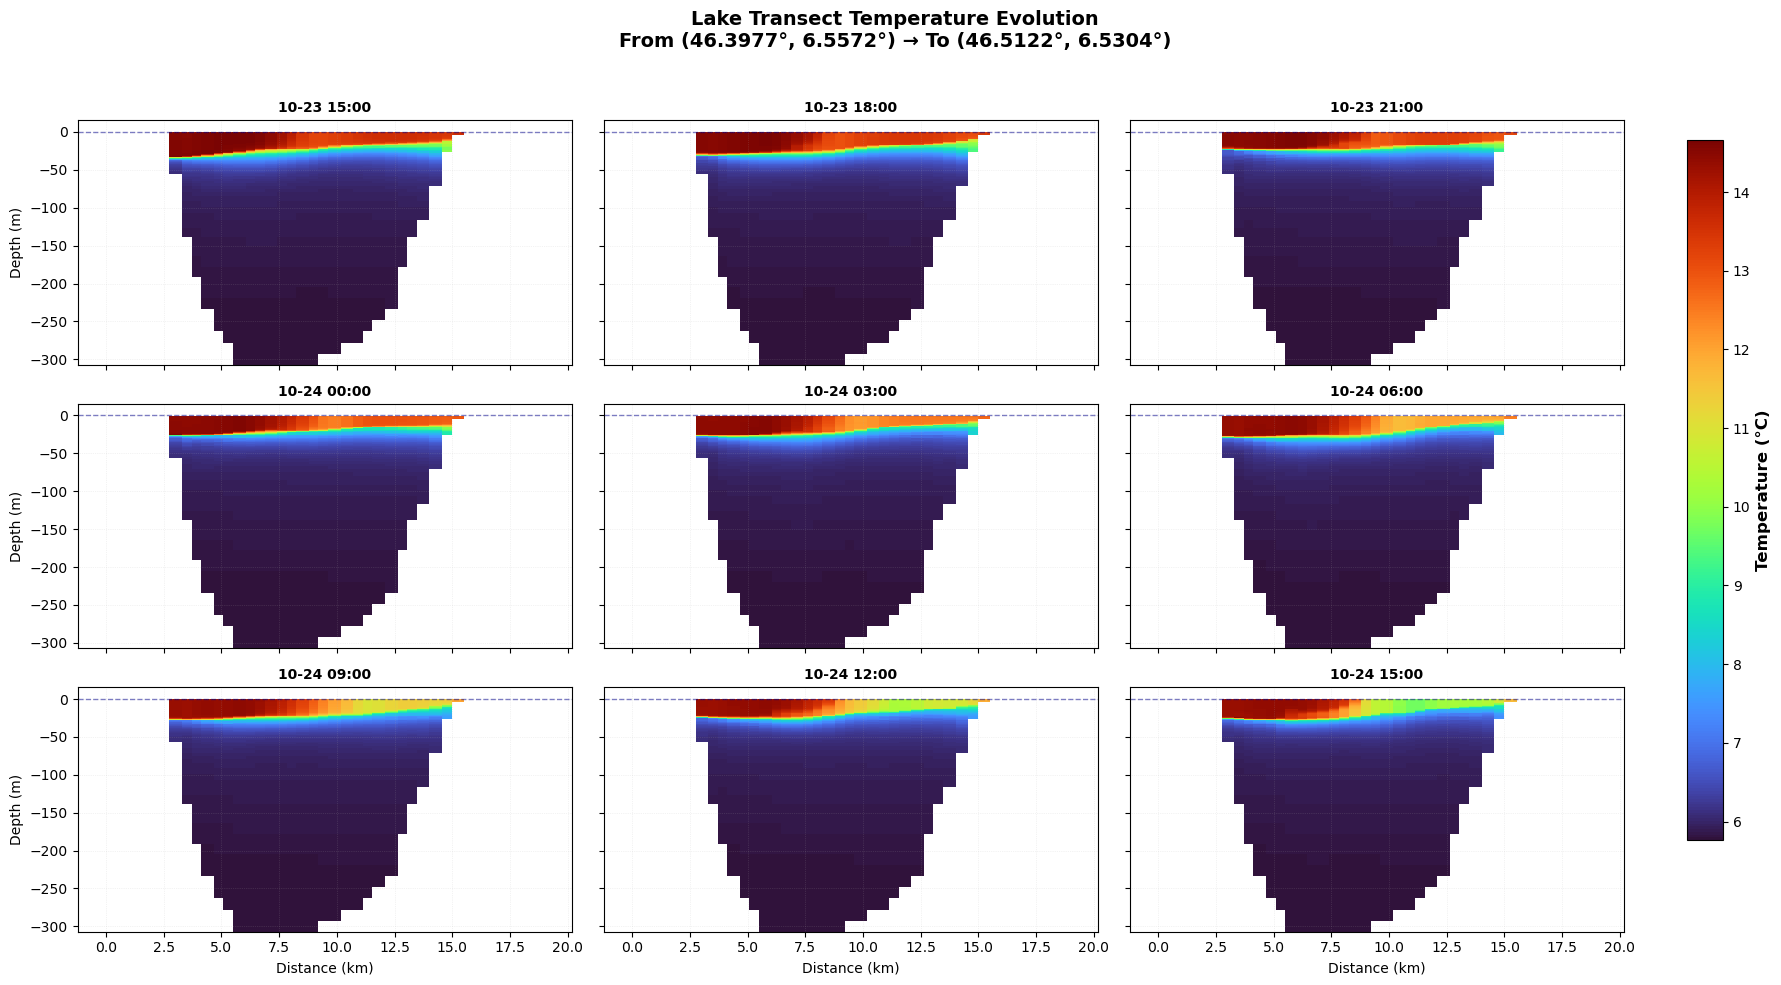

In [5]:
fetch_and_save_alplakes_data_transect(lake='geneva', start_time='202510231500', end_time='202510241500', lat=['46.37', '46.54'], lon=['6.56', '6.54'] 
, variables=['temperature', 'velocity'], model='delft3d-flow')

fig, axes = plot_alplakes_transect_timeseries(data, cmap='turbo')
plt.show()

In [4]:


def _find_time_index(time_list, time_input):
    """
    Find the index of a time in the time list.
    
    Parameters:
    -----------
    time_list : list
        List of time strings from the data
    time_input : str, datetime, int, or None
        The time to find
    
    Returns:
    --------
    int : The index of the matching time
    """
    # If None, return first index
    if time_input is None:
        return 0
    
    # If integer, use directly as index
    if isinstance(time_input, int):
        if time_input < 0:
            return len(time_list) + time_input  # Handle negative indexing
        return time_input
    
    # Convert input to datetime for comparison
    if isinstance(time_input, str):
        # Handle various string formats
        time_input = time_input.replace('Z', '+00:00')  # Handle Z timezone
        # Try parsing with different formats
        try:
            target_dt = datetime.fromisoformat(time_input)
        except:
            # Try without timezone
            try:
                target_dt = datetime.strptime(time_input, '%Y-%m-%d %H:%M:%S')
            except:
                try:
                    target_dt = datetime.strptime(time_input, '%Y-%m-%d %H:%M')
                except:
                    try:
                        target_dt = datetime.strptime(time_input, '%Y-%m-%dT%H:%M:%S')
                    except:
                        raise ValueError(f"Could not parse time string: {time_input}")
    elif isinstance(time_input, datetime):
        target_dt = time_input
    else:
        raise ValueError(f"time must be str, datetime, int, or None, got {type(time_input)}")
    
    # Convert all times in list to datetime and find closest match
    time_dts = []
    for t_str in time_list:
        t_str = t_str.replace('Z', '+00:00')
        try:
            time_dts.append(datetime.fromisoformat(t_str))
        except:
            time_dts.append(datetime.strptime(t_str, '%Y-%m-%dT%H:%M:%S'))
    
    # Make target_dt timezone-aware if comparing with timezone-aware times
    if time_dts and time_dts[0].tzinfo is not None and target_dt.tzinfo is None:
        # Make target timezone aware (assume UTC)
        from datetime import timezone
        target_dt = target_dt.replace(tzinfo=timezone.utc)
    elif time_dts and time_dts[0].tzinfo is None and target_dt.tzinfo is not None:
        # Make time_dts timezone aware
        from datetime import timezone
        time_dts = [t.replace(tzinfo=timezone.utc) if t.tzinfo is None else t for t in time_dts]
    
    # Find exact match or closest time
    if target_dt in time_dts:
        return time_dts.index(target_dt)
    
    # Find closest time
    time_diffs = [abs((t - target_dt).total_seconds()) for t in time_dts]
    closest_idx = time_diffs.index(min(time_diffs))
    
    # Warn if not exact match
    print(f"Note: Exact time not found. Using closest time: {time_list[closest_idx]}")
    
    return closest_idx

def plot_alplakes_transect(data, time=None, figsize=(16, 8), 
                          plot_temp=True, plot_velocity=True, cmap='jet',
                          quiver_scale=50, quiver_width=0.002, alpha_quiver=0.6):
    """
    Plot lake temperature and/or velocity for a transect cross-section
    
    Parameters:
    -----------
    data : dict
        The JSON data from Alplakes transect API
    time : str, datetime, or int, optional
        Which time to plot. Can be:
        - String in ISO format: '2025-10-23T15:00:00' or '2025-10-23 15:00'
        - datetime object
        - Integer index (0 for first, -1 for last)
        - None (default): uses first time step
    figsize : tuple, optional
        Figure size in inches (default: (16, 8))
    plot_temp : bool, optional
        Whether to plot temperature (default: True)
    plot_velocity : bool, optional
        Whether to plot velocity arrows (default: True)
    cmap : str, optional
        Colormap for temperature (default: 'jet')
        Other options: 'viridis', 'plasma', 'turbo', 'coolwarm', 'RdYlBu_r'
    quiver_scale : float, optional
        Scale for velocity arrows - larger values = smaller arrows (default: 50)
        Try values between 20-100 depending on velocity magnitude
    quiver_width : float, optional
        Width of velocity arrows (default: 0.002)
    alpha_quiver : float, optional
        Transparency of velocity arrows (default: 0.6)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    
    Examples:
    ---------
    >>> import json
    >>> with open('transect_data.json', 'r') as f:
    ...     data = json.load(f)
    
    # Plot first time step (default)
    >>> fig, ax = plot_alplakes_transect(data)
    
    # Plot specific date/time
    >>> fig, ax = plot_alplakes_transect(data, time='2025-10-23T15:00:00')
    >>> fig, ax = plot_alplakes_transect(data, time='2025-10-23 15:00')
    
    # Plot using index
    >>> fig, ax = plot_alplakes_transect(data, time=0)  # First
    >>> fig, ax = plot_alplakes_transect(data, time=-1)  # Last
    
    >>> plt.show()
    """
    
    # Find the time index
    time_index = _find_time_index(data['time'], time)
    
    # Extract data
    distance = np.array(data['distance']['data'], dtype=float)  # Distance along transect
    depth = np.array(data['depth']['data'], dtype=float)  # Depth levels
    time_str = data['time'][time_index]  # Time string for this snapshot
    lat = np.array(data['lat'], dtype=float)
    lng = np.array(data['lng'], dtype=float)
    
    # Get the 3D data arrays [time, depth, distance]
    temp_3d = np.array(data['variables']['temperature']['data'], dtype=float)
    u_3d = np.array(data['variables']['u']['data'], dtype=float)  # Eastward velocity
    v_3d = np.array(data['variables']['v']['data'], dtype=float)  # Northward velocity
    
    # Extract the 2D slice for this time step [depth, distance]
    temp_2d = temp_3d[time_index, :, :]
    u_2d = u_3d[time_index, :, :]
    v_2d = v_3d[time_index, :, :]
    
    # Convert depth to negative values (for plotting with depth on y-axis)
    depth_negative = -np.abs(depth)
    
    # Create meshgrid for plotting
    Distance, Depth = np.meshgrid(distance, depth_negative)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot temperature as pcolormesh if requested
    if plot_temp:
        # Mask out NaN values for better visualization
        temp_masked = np.ma.masked_invalid(temp_2d)
        
        mesh = ax.pcolormesh(Distance/1000, Depth, temp_masked, 
                            cmap=cmap, shading='auto')
        
        # Add colorbar
        cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', 
                           pad=0.02, aspect=30)
        cbar.set_label('Temperature (°C)', fontsize=12)
    
    # Plot velocity vectors if requested
    if plot_velocity:
        # Calculate velocity magnitude for the transect
        # For a vertical transect, we need the component perpendicular to the transect
        # and the vertical component (if available)
        
        # Calculate horizontal velocity magnitude
        vel_horizontal = np.sqrt(u_2d**2 + v_2d**2)
        
        # For quiver plot, subsample to avoid overcrowding
        skip_dist = max(1, len(distance) // 30)  # Show ~30 arrows horizontally
        skip_depth = max(1, len(depth) // 20)     # Show ~20 arrows vertically
        
        # Create subsampled arrays
        Distance_sub = Distance[::skip_depth, ::skip_dist]
        Depth_sub = Depth[::skip_depth, ::skip_dist]
        u_sub = u_2d[::skip_depth, ::skip_dist]
        v_sub = v_2d[::skip_depth, ::skip_dist]
        
        # Calculate the angle of the transect to get proper velocity components
        # Transect direction (approximate as linear for velocity projection)
        delta_lat = lat[-1] - lat[0]
        delta_lng = lng[-1] - lng[0]
        transect_angle = np.arctan2(delta_lat, delta_lng)
        
        # Project velocity onto transect direction (along-transect component)
        # Positive = flow in direction of transect
        vel_along = u_sub * np.cos(transect_angle) + v_sub * np.sin(transect_angle)
        
        # For now, we don't have vertical velocity, so use zeros
        # If vertical velocity data exists in future, it can be added here
        vel_vertical = np.zeros_like(vel_along)
        
        # Filter out NaN values
        valid = ~(np.isnan(Distance_sub) | np.isnan(Depth_sub) | 
                 np.isnan(vel_along) | np.isnan(vel_vertical))
        
        # Plot velocity arrows
        quiver = ax.quiver(Distance_sub[valid]/1000, Depth_sub[valid], 
                          vel_along[valid], vel_vertical[valid],
                          scale=quiver_scale, width=quiver_width,
                          color='black', alpha=alpha_quiver,
                          headwidth=3, headlength=4)
        
        # Calculate reference velocity for quiver key
        vel_mag = np.sqrt(vel_along[valid]**2 + vel_vertical[valid]**2)
        ref_velocity = np.round(np.nanmax(vel_mag) * 0.15, 2)
        if ref_velocity == 0 or np.isnan(ref_velocity):
            ref_velocity = 0.1
        
        # Add quiver key
        ax.quiverkey(quiver, 0.85, 0.95, ref_velocity, 
                    f'{ref_velocity} m/s', 
                    labelpos='E', coordinates='figure',
                    color='black', labelcolor='black')
    
    # Add reference line at surface (depth = 0)
    ax.axhline(y=0, color='darkblue', linestyle='--', linewidth=1.5, 
               alpha=0.7, label='Surface')
    
    # Labels and formatting
    ax.set_xlabel('Distance along transect (km)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Depth (m)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Format time string for title
    try:
        dt = datetime.fromisoformat(time_str.replace('Z', '+00:00'))
        time_formatted = dt.strftime('%Y-%m-%d %H:%M UTC')
    except:
        time_formatted = time_str
    
    # Dynamic title based on what's plotted
    title_parts = []
    if plot_temp:
        title_parts.append('Temperature')
    if plot_velocity:
        title_parts.append('Currents')
    
    title = f"Lake Transect - {' & '.join(title_parts)}\n{time_formatted}"
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Add transect endpoints info as text
    coord_text = f"From: ({lat[0]:.4f}°, {lng[0]:.4f}°) → To: ({lat[-1]:.4f}°, {lng[-1]:.4f}°)"
    ax.text(0.5, -0.12, coord_text, transform=ax.transAxes,
           ha='center', fontsize=9, style='italic', color='gray')
    
    # Set y-axis limits to show only where we have data
    max_depth = np.nanmin(depth_negative)  # Most negative = deepest
    ax.set_ylim(max_depth * 1.05, 5)  # Add 5% margin and go slightly above surface
    
    plt.tight_layout()
    return fig, ax


def plot_alplakes_transect_timeseries(data, figsize=(18, 10), 
                                     plot_temp=True, cmap='jet',
                                     levels=20, time_range=None):
    """
    Plot temperature evolution over time as a time-depth contour plot
    
    Parameters:
    -----------
    data : dict
        The JSON data from Alplakes transect API
    figsize : tuple, optional
        Figure size in inches (default: (18, 10))
    plot_temp : bool, optional
        Whether to plot temperature (default: True)
    cmap : str, optional
        Colormap for temperature (default: 'jet')
    levels : int, optional
        Number of contour levels (default: 20)
    time_range : tuple of (start, end), optional
        Time range to plot. Each can be:
        - String in ISO format: '2025-10-23T15:00:00'
        - datetime object
        - Integer index
        - None (uses all times)
        Example: ('2025-10-23T15:00', '2025-10-24T06:00')
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    
    Examples:
    ---------
    >>> # Plot all time steps
    >>> fig, axes = plot_alplakes_transect_timeseries(data)
    
    >>> # Plot specific time range
    >>> fig, axes = plot_alplakes_transect_timeseries(
    ...     data, 
    ...     time_range=('2025-10-23T15:00', '2025-10-24T06:00')
    ... )
    
    >>> plt.show()
    """
    
    # Extract data
    times = data['time']
    distance = np.array(data['distance']['data'], dtype=float)
    depth = np.array(data['depth']['data'], dtype=float)
    
    # Filter time range if specified
    if time_range is not None:
        start_time, end_time = time_range
        start_idx = _find_time_index(times, start_time) if start_time is not None else 0
        end_idx = _find_time_index(times, end_time) if end_time is not None else len(times) - 1
        
        # Create filtered lists
        time_indices = range(start_idx, end_idx + 1)
        times = [times[i] for i in time_indices]
    else:
        time_indices = range(len(times))
    
    # Get the 3D temperature data [time, depth, distance]
    temp_3d = np.array(data['variables']['temperature']['data'], dtype=float)
    
    # Convert depth to negative values
    depth_negative = -np.abs(depth)
    
    # Create figure with subplots for each time step
    n_times = len(times)
    n_cols = 3
    n_rows = int(np.ceil(n_times / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, 
                            sharex=True, sharey=True)
    axes = axes.flatten() if n_times > 1 else [axes]
    
    # Get global min/max for consistent color scale
    temp_min = np.nanmin(temp_3d)
    temp_max = np.nanmax(temp_3d)
    
    # Create meshgrid
    Distance, Depth = np.meshgrid(distance, depth_negative)
    
    for plot_idx, time_idx in enumerate(time_indices):
        if plot_idx >= n_times:
            axes[plot_idx].set_visible(False)
            continue
            
        ax = axes[plot_idx]
        time_str = times[plot_idx]
        
        # Get 2D slice for this time
        temp_2d = temp_3d[time_idx, :, :]
        temp_masked = np.ma.masked_invalid(temp_2d)
        
        # Plot
        mesh = ax.pcolormesh(Distance/1000, Depth, temp_masked, 
                           cmap=cmap, shading='auto',
                           vmin=temp_min, vmax=temp_max)
        
        # Format time
        try:
            dt = datetime.fromisoformat(time_str.replace('Z', '+00:00'))
            time_formatted = dt.strftime('%m-%d %H:%M')
        except:
            time_formatted = time_str[:16]
        
        ax.set_title(time_formatted, fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)
        ax.axhline(y=0, color='darkblue', linestyle='--', 
                  linewidth=1, alpha=0.5)
        
        # Labels only on left and bottom
        if plot_idx % n_cols == 0:
            ax.set_ylabel('Depth (m)', fontsize=10)
        if plot_idx >= n_times - n_cols:
            ax.set_xlabel('Distance (km)', fontsize=10)
    
    # Add single colorbar for all subplots
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    cbar.set_label('Temperature (°C)', fontsize=12, fontweight='bold')
    
    # Overall title
    lat = np.array(data['lat'], dtype=float)
    lng = np.array(data['lng'], dtype=float)
    fig.suptitle(f'Lake Transect Temperature Evolution\n' + 
                f'From ({lat[0]:.4f}°, {lng[0]:.4f}°) → ' +
                f'To ({lat[-1]:.4f}°, {lng[-1]:.4f}°)',
                fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 0.92, 0.96])
    return fig, axes


# Example usage and documentation
if __name__ == "__main__":
    print("""
    Lake Transect Plotting Functions
    =================================
    
    Two main functions are available:
    
    1. plot_alplakes_transect()
       - Plot a single time snapshot of the transect
       - Shows temperature and/or velocity currents
       - Good for detailed analysis of one moment in time
       - Access by date/time string or index
    
    2. plot_alplakes_transect_timeseries()
       - Plot all time steps (or a range) in a grid
       - Shows temperature evolution over time
       - Good for seeing temporal changes
       - Can filter by time range
    
    Example usage:
    --------------
    import json
    import matplotlib.pyplot as plt
    
    # Load your JSON data
    with open('transect_data.json', 'r') as f:
        data = json.load(f)
    
    # Plot specific date/time
    fig, ax = plot_alplakes_transect(data, time='2025-10-23T15:00:00')
    plt.show()
    
    # Plot using simpler date format
    fig, ax = plot_alplakes_transect(data, time='2025-10-23 15:00')
    plt.show()
    
    # Plot first time step
    fig, ax = plot_alplakes_transect(data, time=0)
    plt.show()
    
    # Plot last time step
    fig, ax = plot_alplakes_transect(data, time=-1)
    plt.show()
    
    # Plot all time steps
    fig, axes = plot_alplakes_transect_timeseries(data, cmap='turbo')
    plt.show()
    
    # Plot specific time range
    fig, axes = plot_alplakes_transect_timeseries(
        data, 
        time_range=('2025-10-23T15:00', '2025-10-24T06:00')
    )
    plt.show()
    
    # Customize the plot
    fig, ax = plot_alplakes_transect(
        data, 
        time='2025-10-23T18:00:00',
        figsize=(20, 10),
        cmap='coolwarm',
        quiver_scale=30,  # Larger arrows
        plot_velocity=True
    )
    plt.show()
    """)


    Lake Transect Plotting Functions

    Two main functions are available:

    1. plot_alplakes_transect()
       - Plot a single time snapshot of the transect
       - Shows temperature and/or velocity currents
       - Good for detailed analysis of one moment in time
       - Access by date/time string or index

    2. plot_alplakes_transect_timeseries()
       - Plot all time steps (or a range) in a grid
       - Shows temperature evolution over time
       - Good for seeing temporal changes
       - Can filter by time range

    Example usage:
    --------------
    import json
    import matplotlib.pyplot as plt

    # Load your JSON data
    with open('transect_data.json', 'r') as f:
        data = json.load(f)

    # Plot specific date/time
    fig, ax = plot_alplakes_transect(data, time='2025-10-23T15:00:00')
    plt.show()

    # Plot using simpler date format
    fig, ax = plot_alplakes_transect(data, time='2025-10-23 15:00')
    plt.show()

    # Plot first time step
    

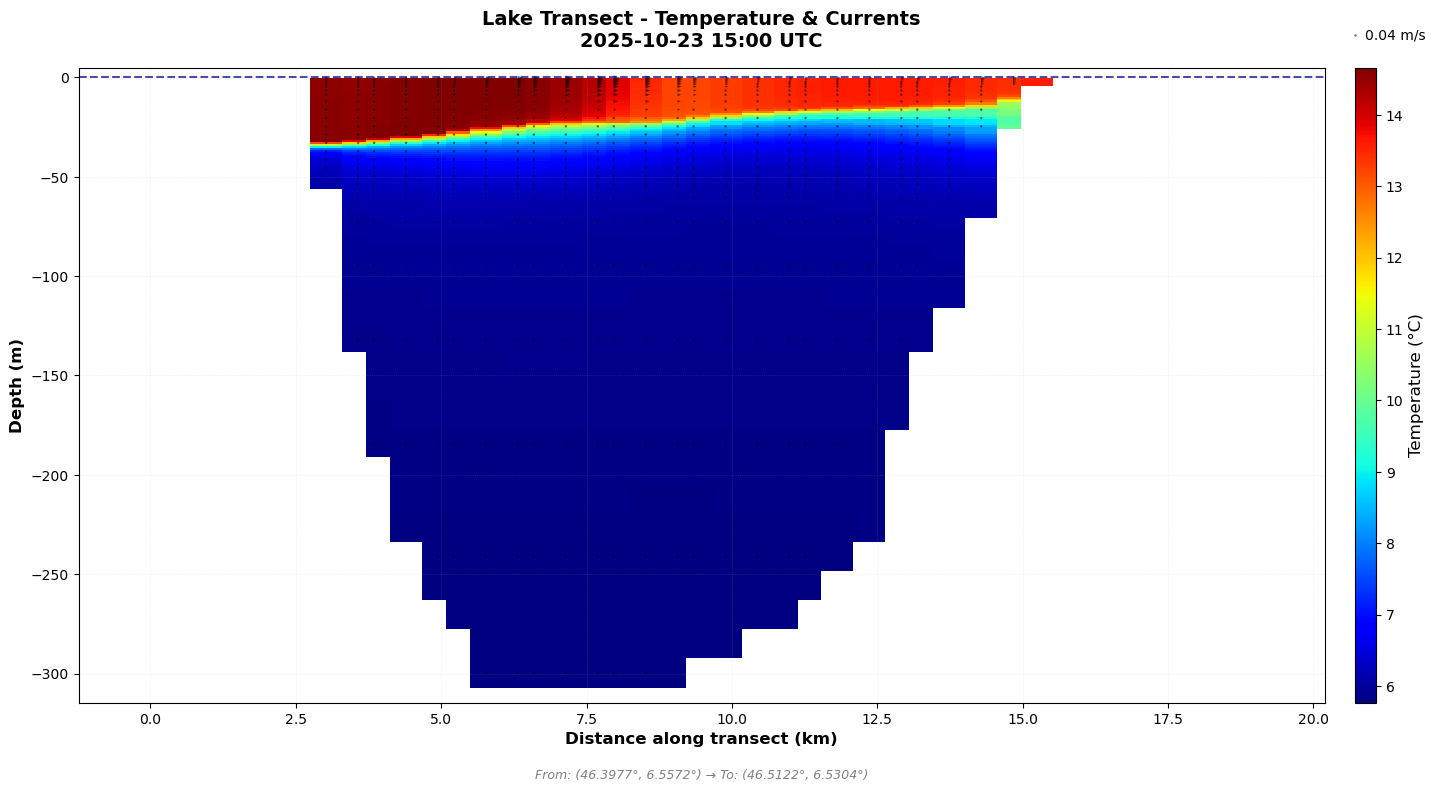

In [6]:
fig, ax = plot_alplakes_transect(data, time='2025-10-23 15:00')
plt.show()

In [ ]:
fig, axes = plot_alplakes_transect_timeseries(data, cmap='turbo')
plt.show()
    

In [7]:
data

{'time': ['2025-10-23T15:00:00+00:00',
  '2025-10-23T18:00:00+00:00',
  '2025-10-23T21:00:00+00:00',
  '2025-10-24T00:00:00+00:00',
  '2025-10-24T03:00:00+00:00',
  '2025-10-24T06:00:00+00:00',
  '2025-10-24T09:00:00+00:00',
  '2025-10-24T12:00:00+00:00',
  '2025-10-24T15:00:00+00:00'],
 'lat': [46.39772,
  46.39772,
  46.39772,
  46.40194,
  46.40615,
  46.41035,
  46.41453,
  46.41868,
  46.42278,
  46.42685,
  46.43088,
  46.43489,
  46.43893,
  46.443,
  46.44714,
  46.45137,
  46.4557,
  46.4601,
  46.46454,
  46.46901,
  46.47347,
  46.47791,
  46.48232,
  46.4867,
  46.49107,
  46.49544,
  46.49983,
  46.50423,
  46.50867,
  46.50867,
  46.51217,
  46.51217],
 'lng': [6.55725,
  6.55725,
  6.55725,
  6.55666,
  6.55607,
  6.55551,
  6.55496,
  6.55442,
  6.55391,
  6.55341,
  6.55292,
  6.55243,
  6.55194,
  6.55145,
  6.55095,
  6.55045,
  6.54995,
  6.54946,
  6.54898,
  6.54852,
  6.54807,
  6.54764,
  6.54721,
  6.54679,
  6.54637,
  6.54594,
  6.54549,
  6.54502,
  6.54451,